# MTRN4110 Phase C - Computer Vision

**File:**           z5260252_MTRN4110_PhaseC.ipynb  
**Date:**           14/07/2022  
**Description:**    Phase C - Computer Vision  
**Author:**         Gajendra Jayasekera (z5260252)  
**Modifications:**  
**Platform:**       MacOS  

In [12]:
# Import libraries.
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Global variables.
MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"
MAP_FILE_NAME = "../MapBuilt.txt"
ROWS = 5
COLUMNS = 9

## Read in an image and display it in RGB mode

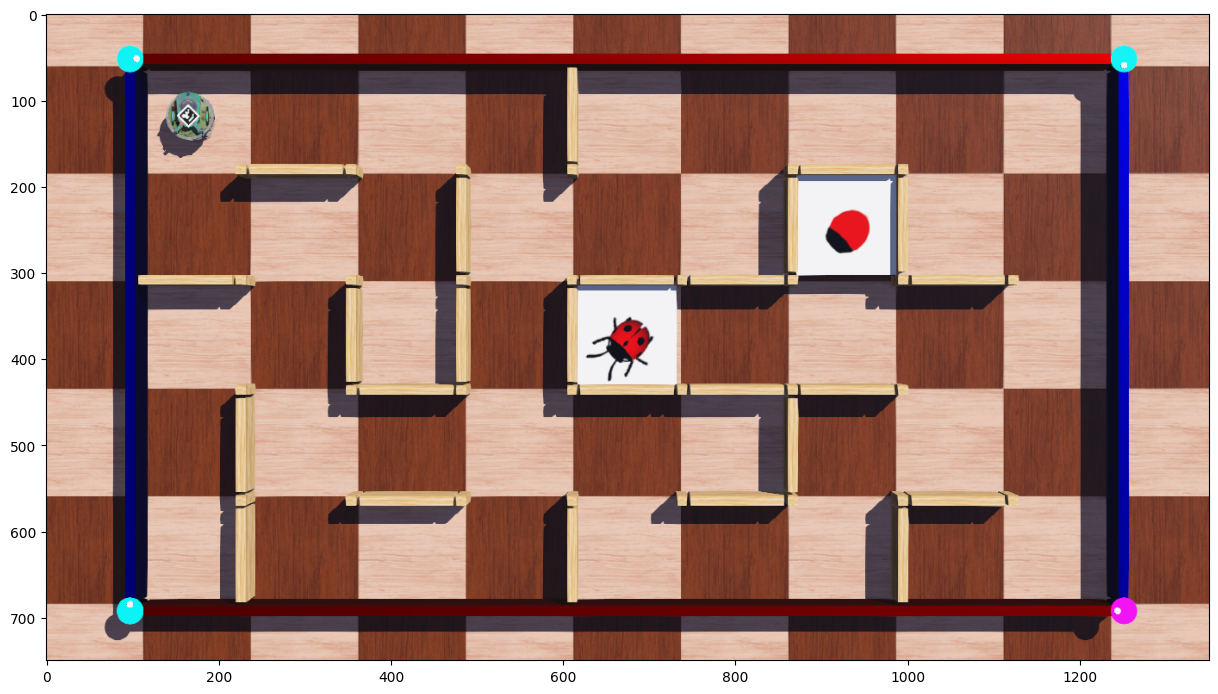

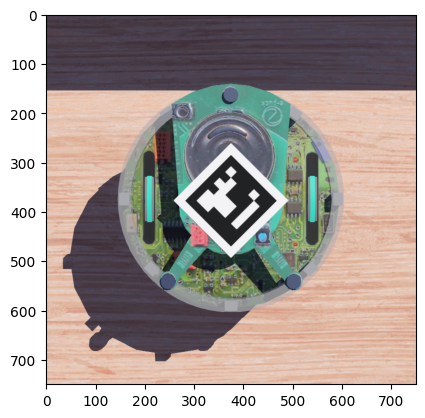

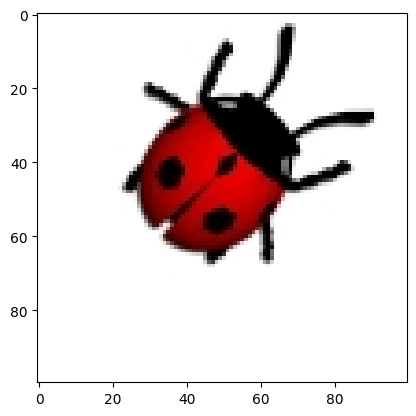

In [14]:
# Read in and display maze in RGB.
maze_BGR = cv2.imread(MAZE_FILE_NAME)
maze_RGB = cv2.cvtColor(maze_BGR, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(maze_RGB)
plt.show()

# Read in and display robot in RGB.
robot_BGR = cv2.imread(ROBOT_FILE_NAME)
robot_RGB = cv2.cvtColor(robot_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(robot_RGB)
plt.show()

# Read in and display ladybug in RGB.
ladybug_BGR = cv2.imread(IMAGE_LADYBUG_FILE_NAME)
ladybug_RGB = cv2.cvtColor(ladybug_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(ladybug_RGB)
plt.show()

## Find the four ordered cornerstones of the maze

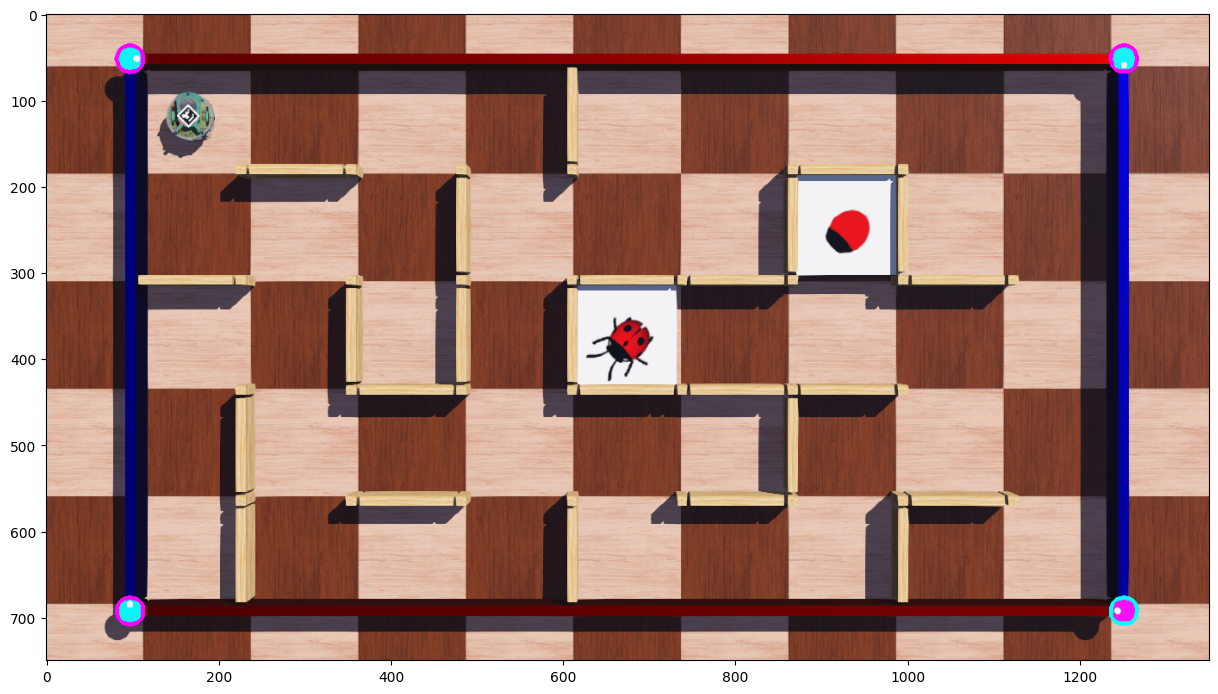

In [15]:
# Code adapted from: https://stackoverflow.com/questions/38827505/detecting-colored-circle-and-its-center-using-opencv
# and opencv_exercise from tutorial.

# Copy of BGR maze to draw on.
maze_BGR_corners = maze_BGR
# Convert from BRG -> HSV - Hue, Saturation, Value.
maze_HSV = cv2.cvtColor(maze_BGR_corners, cv2.COLOR_BGR2HSV)

# Set ranges of cyan and pink cornerstones in maze_HSV.
lower_cyan = np.array([85,120,100])
upper_cyan = np.array([95,255,255])
lower_pink = np.array([145,120,100])
upper_pink = np.array([160,255,255])

# Create and apply cyan and pink masks to the image.
mask_cyan = cv2.inRange(maze_HSV, lower_cyan, upper_cyan)
cyan_RGB = cv2.bitwise_and(maze_RGB, maze_RGB, mask = mask_cyan)
mask_pink = cv2.inRange(maze_HSV, lower_pink, upper_pink)
pink_RGB = cv2.bitwise_and(maze_RGB, maze_RGB, mask = mask_pink)

# Gray for noise clean up.
cyan_GRAY = cv2.cvtColor(cyan_RGB, cv2.COLOR_RGB2GRAY)
pink_GRAY = cv2.cvtColor(pink_RGB, cv2.COLOR_RGB2GRAY)
# 3x3 kernel for clean up.
kernel = np.ones((3,3), np.uint8)
# Run opening (erosion dilation) for noise clean up.
cyan_opening = cv2.morphologyEx(cyan_GRAY, cv2.MORPH_OPEN, kernel)
pink_opening = cv2.morphologyEx(pink_GRAY, cv2.MORPH_OPEN, kernel)

# Find the circumference of the cyan and pink markers.
cyan_edges = cv2.Canny(cyan_opening, threshold1 = 50, threshold2 = 100, apertureSize = 3)
_, cyan_contours, _ = cv2.findContours(cyan_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pink_edges = cv2.Canny(pink_opening, threshold1 = 50, threshold2 = 100, apertureSize = 3)
_, pink_contours, _ = cv2.findContours(pink_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draws markers around the detected contours of cornerstones.
cv2.drawContours(maze_BGR_corners, cyan_contours, -1, (255, 0, 255), 3)
maze_RGB_corners = cv2.cvtColor(maze_BGR_corners, cv2.COLOR_BGR2RGB)
cv2.drawContours(maze_BGR_corners, pink_contours, -1, (255, 255, 0), 3)
maze_RGB_corners = cv2.cvtColor(maze_BGR_corners, cv2.COLOR_BGR2RGB)

# Display result.
plt.figure(figsize = (15, 10))
plt.imshow(maze_RGB_corners)
plt.show()

## Perspective transform the maze from the original image to a rectangle image

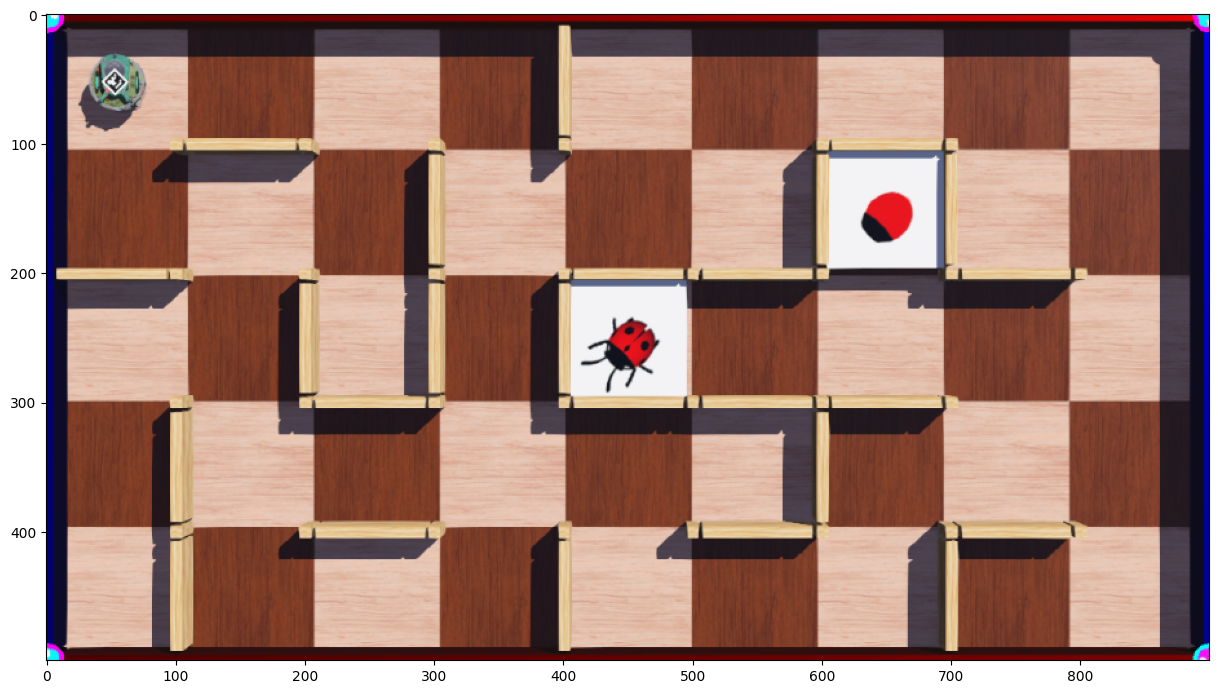

In [16]:
# Find the centres of the cyan and pink cornerstone markers.
# Code adapted from: https://www.geeksforgeeks.org/python-opencv-find-center-of-contour/
cyan_centres = []
for contours in cyan_contours:
    M = cv2.moments(contours)
    # Calculate x and y coordinates of centre.
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cyan_centres.append((cX, cY))

pink_centre = []
M = cv2.moments(pink_contours[0])
if M["m00"] != 0:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    pink_centre.append((cX, cY))

# Determine the order of the 4 maze corners.
for pmarker in pink_centre:
    # Check region A for pink marker.
    if pmarker[0] <= 337.5 and pmarker[1] <= 375:
        for cmarker in cyan_centres:
            # Region B:
            if cmarker[0] >= 1012.5 and cmarker[1] <= 375:
                cyan_marker1 = cmarker
            # Region C:
            elif cmarker[0] <= 337.5 and cmarker[1] >= 375:
                cyan_marker2 = cmarker
            # Region D:
            elif cmarker[0] >= 1012.5 and cmarker[1] >= 375:
                cyan_marker3 = cmarker
    # Check region D for pink marker.
    elif pmarker[0] >= 1012.5 and pmarker[1] >= 375:
        for cmarker in cyan_centres:
            # Region A:
            if cmarker[0] <= 337.5 and cmarker[1] <= 375:
                cyan_marker3 = cmarker
            # Region B:
            elif cmarker[0] >= 1012.5 and cmarker[1] <= 375:
                cyan_marker2 = cmarker
            # Region C:
            elif cmarker[0] <= 337.5 and cmarker[1] >= 375:
                cyan_marker1 = cmarker

# Dimension of new image.
width = int(COLUMNS * 100)
height = int(ROWS * 100)

# Four points of the first image.
image_points1 = np.float32([cyan_marker3, cyan_marker2, cyan_marker1, pmarker])
# Four points on the second image.
image_points2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
# Homography matrix.
H = cv2.getPerspectiveTransform(image_points1, image_points2)
# Tranformed image.
maze_BGR_tranformed = cv2.warpPerspective(maze_BGR_corners, H, (width, height))

# Display result.
maze_RGB_tranformed = cv2.cvtColor(maze_BGR_tranformed, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(maze_RGB_tranformed)
plt.show()

## Detect all the internal walls

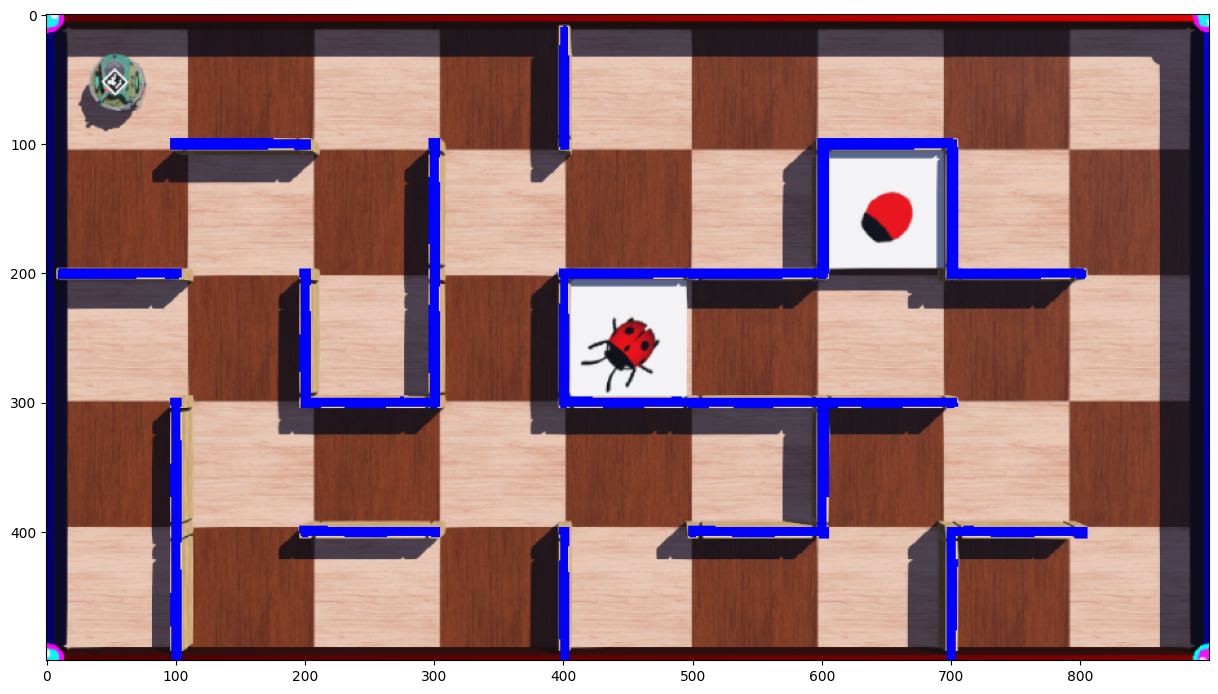

In [17]:
# Convert from BRG -> HSV - Hue, Saturation, Value.
maze_HSV_tranformed = cv2.cvtColor(maze_RGB_tranformed, cv2.COLOR_RGB2HSV)
# Set ranges of wall in maze_HSV.
lower_wall = np.array([15,73,220])
upper_wall = np.array([25,110,255])
# Create and apply wall mask to the image.
mask_wall = cv2.inRange(maze_HSV_tranformed, lower_wall, upper_wall)
wall_RGB = cv2.bitwise_and(maze_RGB_tranformed, maze_RGB_tranformed, mask = mask_wall)

# Gray for noise clean up.
wall_GRAY = cv2.cvtColor(wall_RGB, cv2.COLOR_RGB2GRAY)
# 3x3 kernel for clean up.
kernel = np.ones((3,3), np.uint8)
# Run closing (dilation erosion) for noise clean up + extra steps.
wall_closing = cv2.morphologyEx(wall_GRAY, cv2.MORPH_CLOSE, kernel, iterations = 8)
wall_opening = cv2.morphologyEx(wall_closing, cv2.MORPH_OPEN, kernel)
walls = wall_opening

# Array of all wall pixels.
maze_walls = np.nonzero(walls)
maze_walls_RGB = maze_RGB_tranformed
# Color all wall pixels blue in final image.
maze_walls_RGB[maze_walls] = [0,0,255]

# Display result.
plt.figure(figsize = (15,10))
plt.imshow(maze_walls_RGB)
plt.show()

## Detect the location and heading of the robot

### Location

In [18]:
# Convert from RGB -> HSV - Hue, Saturation, Value.
maze_robot_HSV = cv2.cvtColor(maze_walls_RGB, cv2.COLOR_RGB2HSV)

# Set range of the robot HSV in maze_robot_HSV.
lower_robot = np.array([80,0,0])
upper_robot = np.array([100,230,230])

# Create and apply robot mask to the image.
mask_robot = cv2.inRange(maze_robot_HSV, lower_robot, upper_robot)
robot_mask_RGB = cv2.bitwise_and(maze_walls_RGB, maze_walls_RGB, mask = mask_robot)

# Gray for noise clean up.
cyan_GRAY = cv2.cvtColor(robot_mask_RGB, cv2.COLOR_RGB2GRAY)
# 3x3 kernel for clean up.
kernel = np.ones((3,3), np.uint8)
# Run opening (erosion dilation) for noise clean up.
robot_opening = cv2.morphologyEx(cyan_GRAY, cv2.MORPH_OPEN, kernel)

# Find the circumference of the robot.
robot_edges = cv2.Canny(robot_opening, threshold1 = 50, threshold2 = 100, apertureSize = 3)
_, robot_contours, _ = cv2.findContours(robot_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the centre of the robot.
robot_X = []
robot_Y = []
for contours in robot_contours:
    M = cv2.moments(contours)
    # Get x and y coordinates of contour centres.
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        robot_X.append(cX)
        robot_Y.append(cY)
# ----------------------- Fits to object centre -----------------------
# Find the average of x and y coords to get the centre.
robot_centre = (int(np.mean(robot_X)), int(np.mean(robot_Y)))
#print(robot_centre)
# ------------------------ Fits to cell centre ------------------------
robot_centre = (int(robot_centre[0]/100), int(robot_centre[1]/100))
robot_centre = ((robot_centre[0]*100 + 50), (robot_centre[1]*100 + 50))


### Direction

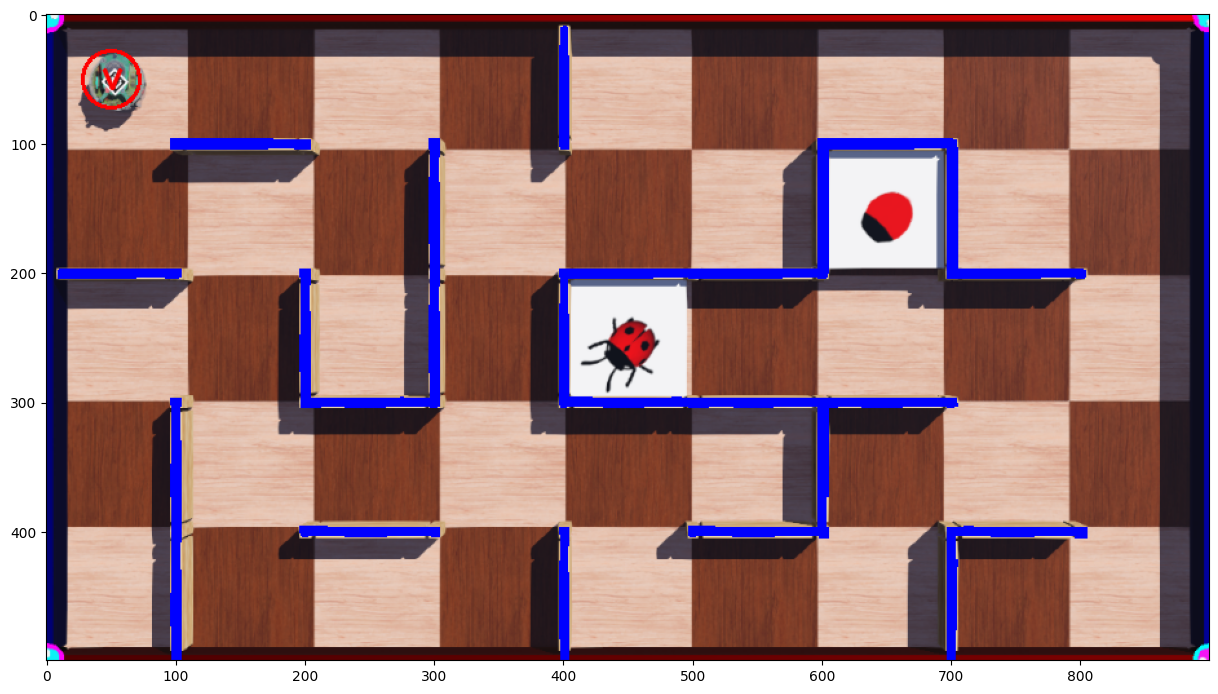

In [19]:
# Load the predefined aruco dictionary.
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
# Initialize the detector parameters using default values.
parameters = cv2.aruco.DetectorParameters_create()

# Apply homography matrix to close up of robot.
robot_BGR_transformed = cv2.warpPerspective(robot_BGR, H, (1500, 1500))
robot_RBG_transformed = cv2.cvtColor(robot_BGR_transformed, cv2.COLOR_BGR2RGB)

# Display result.
#plt.imshow(robot_RBG_transformed)
#plt.show()

# Placeholder until real direction is found.
direction = '^'
marker_found = 0

# Detect aruco marker.
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_RBG_transformed, dictionary, parameters=parameters)
#print(markerCorners)

# While an aruco marker is not detected, translate Robot.png until the marker is detected in the transformed Robot.png.
for d in range(8):
    if not bool(markerCorners) and not marker_found:
        i = 0
        while (not bool(markerCorners)) and (i < 1600):
            # Translate:
            if d == 0: # up.
                M = np.float32([[1, 0, 0], [0, 1, -i]])
            elif d == 1: # up and right.
                M = np.float32([[1, 0, i], [0, 1, -i]])
            elif d == 2: # right.
                M = np.float32([[1, 0, i], [0, 1, 0]])
            elif d == 3: # down and right.
                M = np.float32([[1, 0, i], [0, 1, i]])
            elif d == 4: # down.
                M = np.float32([[1, 0, 0], [0, 1, i]])
            elif d == 5: # down and left.
                M = np.float32([[1, 0, -i], [0, 1, i]])
            elif d == 6: # left.
                M = np.float32([[1, 0, -i], [0, 1, 0]])
            elif d == 7: # up and left.
                M = np.float32([[1, 0, -i], [0, 1, -i]])
            
            # Run detection for marker.
            shifted = cv2.warpAffine(robot_BGR, M, (robot_BGR.shape[1], robot_BGR.shape[0]))
            robot_BGR_transformed = cv2.warpPerspective(shifted, H, (1500, 1500))
            robot_RBG_transformed = cv2.cvtColor(robot_BGR_transformed, cv2.COLOR_BGR2RGB)
            markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_RBG_transformed, dictionary, parameters=parameters)
            i += 100
            if bool(markerCorners):
                marker_found = 1
                break
    if (marker_found):
        break

flag_north = 0
flag_east = 0
flag_south = 0
flag_west = 0
a = 0
b = 0
# Find direction of the robot.
for i in range(len(markerCorners[0][0]) - 1):
    # Check for north (smallest y coord)
    if markerCorners[0][0][0][1] < markerCorners[0][0][i + 1][1]:
        flag_north += 1
        if flag_north >= 2:
            direction = '^'
            # Based on direction, set adjustments for direction drawing.
            a = -10
            b = 9
            # If a more accurate result is found.
            if flag_north == 3:
                direction = '^'
                a = -10
                b = 9

    
    # Check for east (largest x coord)
    if markerCorners[0][0][0][0] > markerCorners[0][0][i + 1][0]:
        flag_east += 1
        if flag_east >= 2:
            direction = '>'
            a = -9
            b = 9
            if flag_east == 3:
                direction = '>'
                a = -9
                b = 9
    
    # Check for south (largest y coord)
    if markerCorners[0][0][0][1] > markerCorners[0][0][i + 1][1]:
        flag_south += 1
        if flag_south >= 2:
            direction = 'v'
            a = -7
            b = 7
            if flag_south == 3:
                direction = 'v'
                a = -7
                b = 7
    
    # Check for south (smallest x coord)
    if markerCorners[0][0][0][0] < markerCorners[0][0][i + 1][0]:
        flag_west += 1
        if flag_west >= 2:
            direction = '<'
            a = -13
            b = 9
            if flag_west == 3:
                direction = '<'
                a = -13
                b = 9

# Draw a circle on the robot location.
maze_robot_RGB = cv2.circle(maze_walls_RGB, robot_centre, 22, (255, 0, 0), 2)
# Draw the direction on the robot location.
maze_robot_RGB = cv2.putText(maze_robot_RGB, direction, (robot_centre[0] + a, robot_centre[1] + b), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# Display result.
plt.figure(figsize = (15,10))
plt.imshow(maze_robot_RGB)
plt.show()

## Detect the position of the true target

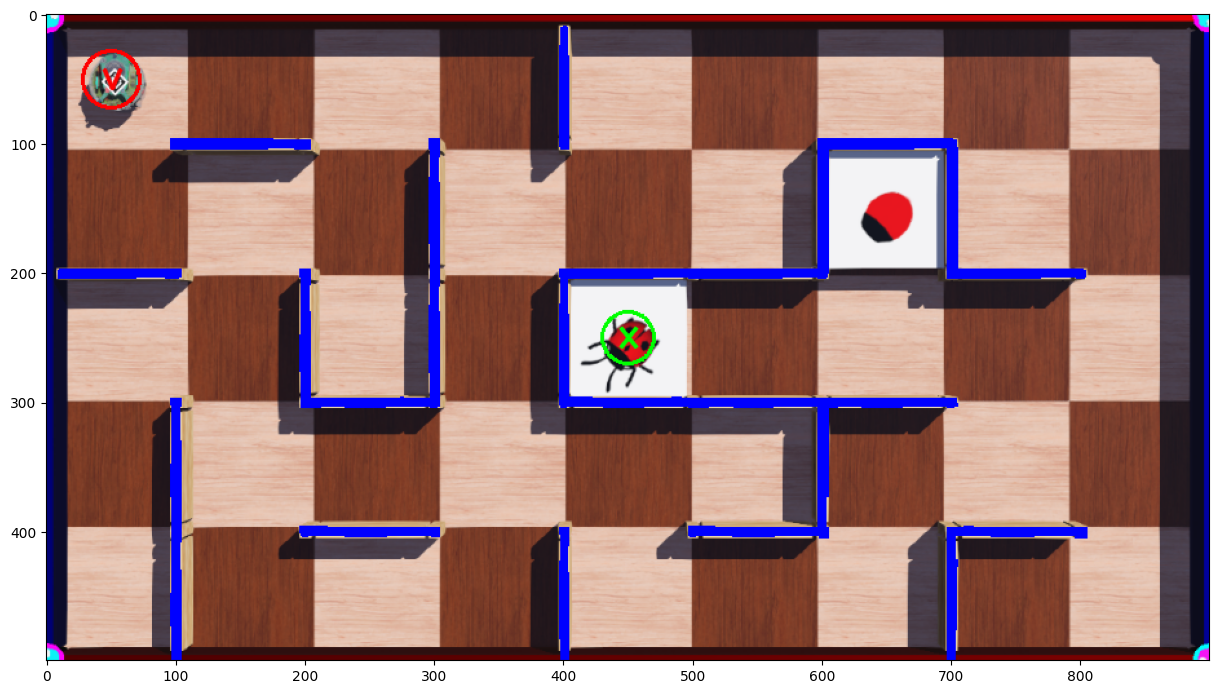

In [20]:
# Code adapted from: https://stackoverflow.com/questions/7853628/how-do-i-find-an-image-contained-within-an-image

# Crop the ladybug image removing white areas to improve accuracy for matching.
ladybug_BGR = ladybug_BGR[1:71, 20:93]
maze_ladybug_BGR = cv2.cvtColor(maze_walls_RGB, cv2.COLOR_RGB2BGR)

# Apply matching template using SQDIFF_NORMED as CCORR approaches are less accurate.
result = cv2.matchTemplate(ladybug_BGR, maze_ladybug_BGR, cv2.TM_SQDIFF_NORMED)
# Take the minimum for squared difference TM method.
mn, _, mnLoc, _ = cv2.minMaxLoc(result)
# Extract the coordinates of the top left of the best match detected.
MPx, MPy = mnLoc

# Determine the centre (col,row) of the ladybug.
# ------------------------ Fits to object centre ------------------------
trows, tcols = ladybug_BGR.shape[:2]
ladybug_centre = (int(MPx + tcols/2), int(MPy + trows/2))
# ------------------------- Fits to cell centre -------------------------
ladybug_centre = (int(ladybug_centre[0]/100), int(ladybug_centre[1]/100))
ladybug_centre = ((ladybug_centre[0]*100 + 50), (ladybug_centre[1]*100 + 50))

# Draw marker where the ladybug is on the maze.
cv2.circle(maze_ladybug_BGR, ladybug_centre, 20, (0, 255, 0), 2)
cv2.putText(maze_ladybug_BGR, 'x', (ladybug_centre[0] - 8, ladybug_centre[1] + 7), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Display result.
maze_ladybug_RGB = cv2.cvtColor(maze_ladybug_BGR, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(maze_ladybug_RGB)
plt.show()

## Generate a map and write it to a text file

### Get robot and goal coordinates and horizontal and vertical wall matrices

In [21]:
# Derive robot and goal coords(row,col) from map centriods.
robot_coords = (int(robot_centre[1]/100), int(robot_centre[0]/100))
#print(robot_coords)
ladybug_coords = (int(ladybug_centre[1]/100), int(ladybug_centre[0]/100))
#print(ladybug_coords)

# 2D arrays to store wall data.
horizontal_walls = np.zeros((ROWS + 1, COLUMNS))
vertical_walls = np.zeros((ROWS, COLUMNS + 1))

# Horizontal walls.
for row in range(ROWS + 1):
    for col in range(COLUMNS):
        # Set boundary walls which are not detected in the wall mask.
        if row == 0 or row == ROWS:
            horizontal_walls[row][col] = int(1)
        else:
            # Set intial pixel position for current row/col.
            x = col * 100
            y = row * 100
            # Count wall pixels in the defined range on the wall mask.
            wall_pixels = cv2.countNonZero(walls[(y - 20):(y + 20), (x + 30):(x + 70)])
            # Average wall pixel count is 320-360 if a wall is there.
            if wall_pixels > 150:
                horizontal_walls[row][col] = int(1)
#print(horizontal_walls)

# Vertical walls.
for row in range(ROWS):
    for col in range(COLUMNS + 1):
        if col == 0 or col == COLUMNS:
            vertical_walls[row][col] = int(1)
        else:
            # Set intial pixel position for current row/col.
            x = col * 100
            y = row * 100
            # Count wall pixels in the defined range on the wall mask.
            wall_pixels = cv2.countNonZero(walls[(y + 30):(y + 70), (x - 20):(x + 20)])
            # Average wall pixel count is 320-360 if a wall is there.
            if wall_pixels > 150:
                vertical_walls[row][col] = int(1)
#print(vertical_walls)

### Generate map and write to TXT file

In [22]:
# Create and open the map file at the specified file path.
map = open(MAP_FILE_NAME, "w")

# Generate the map.
for line in range(ROWS*2 + 1):
    # Horizontal wall lines.
    if line % 2 == 0:
        map.write(" ")
        for col in range(COLUMNS):
            if horizontal_walls[int(line/2)][col] == 1:
                map.write("--- ")
            else:
                map.write("    ")
        map.write("\n")
    # Vertical wall lines.
    else:
        # Check if the robot or ladybug is in the first column.
        if robot_coords[0] == int(line/2) and robot_coords[1] == 0:
            map.write("| " + direction + " ")
        elif ladybug_coords[0] == int(line/2) and ladybug_coords[1] == 0:
            map.write("| x ")
        else:
            map.write("|   ")
            
        for col in range(COLUMNS - 1):
            # Robot location.
            if robot_coords[0] == int(line/2) and robot_coords[1] == col + 1:
                # Check if a wall is there.
                if vertical_walls[int(line/2)][col + 1] == 1:
                    map.write("| " + direction + " ")
                else:
                    map.write("  " + direction + " ")
            # Ladybug location.
            elif ladybug_coords[0] == int(line/2) and ladybug_coords[1] == col + 1:
                # Check if a wall is there.
                if vertical_walls[int(line/2)][col + 1] == 1:
                    map.write("| x ")
                else:
                    map.write("  x ")
            # Wall.
            elif vertical_walls[int(line/2)][col + 1] == 1:
                map.write("|   ")
            else:
                map.write("    ")
        map.write("|\n")

# Save write lines and close.
map.close()